[View in Colaboratory](https://colab.research.google.com/github/neilsun2009/pix2pix_estimator/blob/master/Pix2Pix_Estimator.ipynb)

# Pix2Pix
## With U-Net and PatchGAN
### Using TensorFlow Estimator

## Preperation

In [0]:
import tensorflow as tf

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import PIL
from IPython.display import clear_output

In [0]:
# dataset
path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                     cache_subdir=os.path.abspath('.'),
                                     origin='https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz',
                                     extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUT_CHANNELS = 3
LAMBDA = 100
EPOCHS = 500


def load_image(image_file, is_train):
  image = tf.read_file(image_file)
  image = tf.image.decode_jpeg(image)
  w = tf.shape(image)[1]
  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]
  real_image = tf.cast(real_image, tf.float32)
  input_image = tf.cast(input_image, tf.float32) # RGB [0, 255]
  
  if is_train:
    # random jittering
    # resize to 286 * 286 * 3
    input_image = tf.image.resize_images(input_image, [286, 286],
                                       align_corners=True,
                                       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize_images(real_image, [286, 286],
                                       align_corners=True,
                                       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # random cropping to 256 * 256 * 3
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    input_image, real_image = cropped_image[0], cropped_image[1]
    
    if np.random.random() > 0.5:
      input_image = tf.image.flip_left_right(input_image)
      real_image = tf.image.flip_left_right(real_image)
  else:
    input_image = tf.image.resize_images(input_image, size=[IMG_HEIGHT, IMG_WIDTH], 
                                         align_corners=True, method=2)
    real_image = tf.image.resize_images(real_image, size=[IMG_HEIGHT, IMG_WIDTH], 
                                        align_corners=True, method=2)
  # normalize to [-1, 1]
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1
  return input_image, real_image


In [0]:
# data input function
def train_input_fn():
  train_dataset = tf.data.Dataset.list_files(PATH + 'train/*.jpg')
  train_dataset = train_dataset.shuffle(BUFFER_SIZE)
  train_dataset = train_dataset.map(lambda x: load_image(x, True)).repeat()
  train_dataset = train_dataset.batch(BATCH_SIZE)
  return train_dataset.make_one_shot_iterator().get_next(name='data_input')

def test_input_fn():
  test_dataset = tf.data.Dataset.list_files(PATH + 'test/*.jpg')
  test_dataset = test_dataset.map(lambda x: load_image(x, False))
  test_dataset = test_dataset.batch(BATCH_SIZE)
  return test_dataset.make_one_shot_iterator().get_next()

## Generator & Discriminator

In [0]:
# generator

def downsample(x, filters, size, apply_batchnorm=True): # for both gen and disc
  initializer = tf.initializers.random_normal(0, 0.02)
  output = tf.layers.conv2d(x, filters, kernel_size=size,
                           strides=2, padding='same', use_bias=False,
                           kernel_initializer=initializer)
  if apply_batchnorm:
    output = tf.layers.batch_normalization(output, training=True) # always use training
  output = tf.nn.leaky_relu(output)
  return output

def gen_upsample(x, x2, filters, size, apply_dropout=False):
  initializer = tf.initializers.random_normal(0, 0.02)
  output = tf.layers.conv2d_transpose(x, filters, kernel_size=size,
                           strides=2, padding='same', use_bias=False,
                           kernel_initializer=initializer)
  output = tf.layers.batch_normalization(output, training=True)
  if apply_dropout:
    output = tf.layers.dropout(output, rate=0.5, training=True) # always use training
  output = tf.nn.relu(output)
  output = tf.concat([output, x2], axis=-1) # skip connection
  return output

def generator(x): # 256
  with tf.variable_scope('gen'):
  # encode
    x1 = downsample(x, 64, 4, apply_batchnorm=False) # 128
    x2 = downsample(x1, 128, 4) # 64
    x3 = downsample(x2, 256, 4) # 32
    x4 = downsample(x3, 512, 4) # 16
    x5 = downsample(x4, 512, 4) # 8
    x6 = downsample(x5, 512, 4) # 4
    x7 = downsample(x6, 512, 4) # 2
    x8 = downsample(x7, 512, 4) # 1
    # decode
    x9 = gen_upsample(x8, x7, 512, 4, apply_dropout=True) # 2
    x10 = gen_upsample(x9, x6, 512, 4, apply_dropout=True) # 4
    x11 = gen_upsample(x10, x5, 512, 4, apply_dropout=True) # 8
    x12 = gen_upsample(x11, x4, 512, 4) # 16
    x13 = gen_upsample(x12, x3, 256, 4) # 32
    x14 = gen_upsample(x13, x2, 128, 4) # 64
    x15 = gen_upsample(x14, x1, 64, 4) # 128
    x16 = tf.layers.conv2d_transpose(x15, OUT_CHANNELS, kernel_size=4,
                                    strides=2, padding='same',
                                    kernel_initializer=tf.initializers.random_normal(0, 0.02))
    output = tf.nn.tanh(x16, name='gen_output')
  return output

In [0]:
# discriminator

def discriminator(x, y):
  with tf.variable_scope('disc', reuse=tf.AUTO_REUSE):
    initializer = tf.initializers.random_normal(0, 0.02)
    # like encode
    output = tf.concat([x, y], axis=-1) # 256
    output = downsample(output, 64, 4, apply_batchnorm=False) # 128
    output = downsample(output, 128, 4) # 64
    output = downsample(output, 256, 4) # 32
    # we are zero padding here with 1 because we need our shape to 
    # go from (batch_size, 32, 32, 256) to (batch_size, 31, 31, 512)
    paddings = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    output = tf.pad(output, paddings) # 34
    output = tf.layers.conv2d(output, 512, kernel_size=4,
                             strides=1, padding='valid', use_bias=False,
                             kernel_initializer=initializer) # 31
    output = tf.layers.batch_normalization(output, training=True)
    output = tf.nn.leaky_relu(output)
    # padding same way
    output = tf.pad(output, paddings) # 33
    output = tf.layers.conv2d(output, 1, kernel_size=4,
                             strides=1, padding='valid',
                             kernel_initializer=initializer) # 30
    # don't add a sigmoid activation here since
    # the loss function expects raw logits.
    print(output)
  return output

## Loss

In [0]:
# discriminator loss
def disc_loss(disc_real_output, disc_generated_output):
  real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(disc_real_output),
                                             logits = disc_real_output)
  generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.zeros_like(disc_generated_output),
                                             logits = disc_generated_output)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss

# generator loss
def gen_loss(disc_generated_output, gen_output, target):
  gan_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(disc_generated_output),
                                             logits = disc_generated_output)
  l1_loss = tf.reduce_mean(tf.abs(target-gen_output))
  total_gen_loss = gan_loss + LAMBDA * l1_loss
  return total_gen_loss

## Model

In [0]:
TENSOR_TAGS = ['input', 'target', 'prediction']

# hook for showing predictions
class ShowPredictionHook(tf.train.LoggingTensorHook):
  
  def after_run(self, run_context, run_values):
    if self._should_trigger:
      clear_output(wait=True)
      results = run_values.results
      plt.figure(figsize=(15,15))

      titles = ['Input Image', 'Ground Truth', 'Predicted Image']

      for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(titles[i])
        display = results[TENSOR_TAGS[i]][0]
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display * 0.5 + 0.5)
        plt.axis('off')
      plt.show()
    super(ShowPredictionHook, self).after_run(run_context, run_values)
    

In [0]:
def p2p_model(features, labels, mode, params):
  # with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
  gen_output = generator(features)
  # print(features, labels, gen_output)
  # predict
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode, predictions=gen_output)
  disc_real_output = discriminator(features, labels)
  disc_gen_output = discriminator(features, gen_output)
  gen_loss_value = gen_loss(disc_gen_output, gen_output, labels)
  disc_loss_value = disc_loss(disc_real_output, disc_gen_output)
  tf.summary.scalar('gen_loss', gen_loss_value)
  tf.summary.scalar('disc_loss', disc_loss_value)
  # eval
  if mode == tf.estimator.ModeKeys.EVAL:
    return tf.estimator.EstimatorSpec(mode, loss=gen_loss_value + disc_loss_value,
                                      predictions=gen_output)
  # optimizers
  gen_optimizer = tf.train.AdamOptimizer(2e-4, beta1=0.5)
  disc_optimizer = tf.train.AdamOptimizer(2e-4, beta1=0.5)
  # gen_variables = tf.global_variables(scope='gen/')
  # disc_variables = tf.global_variables(scope='disc/')
  gen_variables = tf.trainable_variables(scope='gen/')
  disc_variables = tf.trainable_variables(scope='disc/')
  
  ## gradient tape is only for eager execution
  # gen_gradients = gen_tape.gradient(gen_loss_value, gen_variables)
  # disc_gradients = disc_tape.gradient(disc_loss_value, disc_variables)
  # gen_train_op = gen_optimizer.apply_gradients(zip(gen_gradients, gen_variables))
  # disc_train_op = disc_optimizer.apply_gradients(zip(disc_gradients, disc_variables))
  step = tf.train.get_global_step()
  update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
  # with tf.control_dependencies(update_ops):
  gen_train_op = gen_optimizer.minimize(gen_loss_value, var_list=gen_variables, 
                                        global_step=step)
  disc_train_op = disc_optimizer.minimize(disc_loss_value, var_list=disc_variables,
                                          global_step=step)
  train_op = tf.group(gen_train_op, disc_train_op)
  print(len(gen_variables))
  print(len(disc_variables))
  # train
  return tf.estimator.EstimatorSpec(mode, loss=gen_loss_value + disc_loss_value,
                                    predictions=gen_output, 
                                    train_op=train_op)


## Train

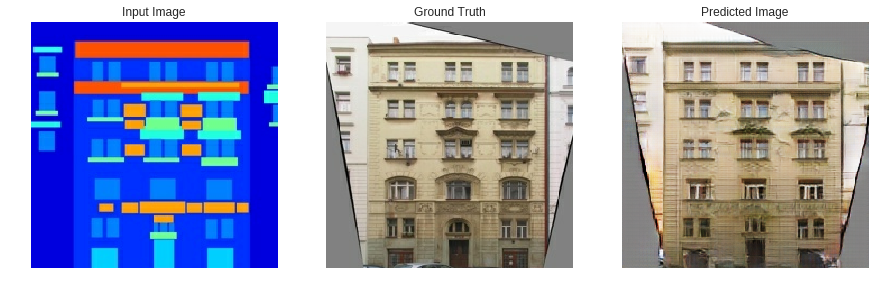

INFO:tensorflow:None
INFO:tensorflow:loss = 19.79551, step = 224122
INFO:tensorflow:global_step/sec: 9.30708
INFO:tensorflow:loss = 23.177654, step = 224322 (19.582 sec)
INFO:tensorflow:global_step/sec: 10.7873
INFO:tensorflow:global_step/sec: 11.9907


KeyboardInterrupt: ignored

In [36]:
checkpointing_config = tf.estimator.RunConfig(
    save_checkpoints_steps = BUFFER_SIZE,
    keep_checkpoint_max = 5,
)
image_builder = tf.estimator.Estimator(model_fn=p2p_model, 
                                       model_dir='./p2p_checkpoints_5',
                                       config=checkpointing_config)
# this hook is used to show current predictions, i.e. the performance of the current net
predict_hook = ShowPredictionHook(tensors={TENSOR_TAGS[0]: 'data_input:0',
                                          TENSOR_TAGS[1]: 'data_input:1',
                                          TENSOR_TAGS[2]: 'gen/gen_output:0'},
                                 every_n_iter=BUFFER_SIZE,
                                 formatter=lambda tensors: None)
image_builder.train(input_fn=train_input_fn,
                    steps=BUFFER_SIZE*EPOCHS/BATCH_SIZE,
                    hooks=[predict_hook])

In [35]:
from google.colab import files
files.download('p2p_checkpoints_5/model.ckpt-224122.data-00000-of-00001')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 44026, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil